In [2]:
import numpy as np 
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO
import supervision as sv
import torch
import pandas as pd
import time
import os

%matplotlib inline

In [2]:
#frames per second function
def get_fps(frame_number):
    if frame_number == 0:
        get_fps.start_time = time.time()
        return 0.0
    end_time = time.time()
    fps = float(frame_number) / float(end_time - get_fps.start_time)
    return fps


### Distance functions

In [2]:
def distance(point, rectangle):
    image = np.zeros((100, 100), dtype='uint8')
    (x0, y0) = point
    (x1,y1) = rectangle[:2]
    (x2,y2) = rectangle[2:]
    
    #minimum distance is in some corner point
    if x0>=x2 and y0<=y1:
        d=np.sqrt((x2-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x2,y1]
    if x0<=x1 and y0<=y1:
        d=np.sqrt((x1-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x1,y1]  
    if x0<=x1 and y0>=y2:
        d=np.sqrt((x1-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x1,y2]    
    if x0>=x2 and y0>=y2:
        d=np.sqrt((x2-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x2,y2]     
     #minimum distance is on the edge: draw perpendicular to that edge from (x0,y0)
    if x0>=x1 and x0<=x2 and y0>=y2:
        d=y0-y2
        d_coord = [x0,y0, x0,y2] 
    if x0>=x1 and x0<=x2 and y0<=y1:
        d=y1-y0
        d_coord = [x0,y0, x0,y1]  
    if y0>=y1 and y0<=y2 and x0>=x2:
        d=x0-x2
        d_coord = [x0,y0, x2,y0] 
    if y0>=y1 and y0<=y2 and x0<=x1:
        d=x1-x0
        d_coord = [x0,y0, x1,y0]   
    # point is inside rectangle  - distance is the distance between two centers  
    if x0>=x1 and x0<=x2 and y0>=y1 and y0<=y2:
        center_x = int((x1+x2)/2)
        center_y = int((y1+y2)/2)
        d=np.sqrt((center_x-x0)**2+(center_y-y0)**2)
        d_coord = [x0,y0, center_x, center_y] 
        print(d_coord)     
        
    #draw distance
    cv2.rectangle(image, (x1, y1), (x2, y2), color=(255,0,0), thickness=1)
    cv2.circle(image, (x0,y0), radius=0, color=(255, 0, 0), thickness=-1)
    cv2.line(image, d_coord[:2], d_coord[2:], color = (255, 255, 255), thickness=1)
    plt.imshow(image)
    plt.axis("off")
    return d

[50, 50, 70, 60]
22.360679774997898


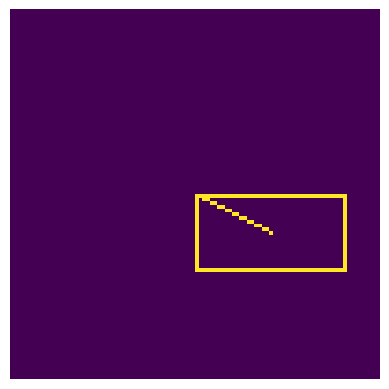

In [4]:
d = distance([50,50], [50, 50, 90, 70])
print(d)

In [2]:
def get_distance(rect1, rect2):
    # take senter of person as a point
    (x0, y0) = int((rect1[0]+rect1[2])/2), int((rect1[1]+rect1[3])/2)
    (x1,y1) = rect2[:2]
    (x2,y2) = rect2[2:]
    
    #d=0
    
    #minimum distance is in some corner point
    if x0>x2 and y0<y1:
        d=np.sqrt((x2-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x2,y1]
    if x0<x1 and y0<y1:
        d=np.sqrt((x1-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x1,y1]  
    if x0<x1 and y0>y2:
        d=np.sqrt((x1-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x1,y2]    
    if x0>x2 and y0>y2:
        d=np.sqrt((x2-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x2,y2]     
     #minimum distance is on the edge: draw perpendicular to that edge from (x0,y0)
    if x0>=x1 and x0<=x2 and y0>=y2:
        d=y0-y2
        d_coord = [x0,y0, x0,y2] 
    if x0>=x1 and x0<=x2 and y0<=y1:
        d=y1-y0
        d_coord = [x0,y0, x0,y1]  
    if y0>=y1 and y0<=y2 and x0>=x2:
        d=x0-x2
        d_coord = [x0,y0, x2,y0] 
    if y0>=y1 and y0<=y2 and x0<=x1:
        d=x1-x0
        d_coord = [x0,y0, x1,y0]      
    if x0>=x1 and x0<=x2 and y0>=y1 and y0<=y2:
        center_x = int((x1+x2)/2)
        center_y = int((y1+y2)/2)
        d=np.sqrt((center_x-x0)**2+(center_y-y0)**2)
        d_coord = [x0,y0, center_x, center_y] 
        
    
    return d, d_coord

In [16]:
def get_circular_distance(rect1, rect2):
    # take senter of person as a point
    (x0, y0) = int((rect1[0]+rect1[2])/2), int((rect1[1]+rect1[3])/2)
    (x1,y1) = int((rect2[0]+rect2[2])/2), int((rect2[1]+rect2[3])/2)
    
    d=np.sqrt((x1-x0)**2+(y1-y0)**2)
    d_coord = [x0,y0, x1,y1]
    
    
    return d, d_coord

In [3]:
def intersection_distance(rect1, rect2):
    (x11, y11, x12, y12) = rect1
    (x21, y21, x22, y22) = rect2
    
    #coordinates of intersection
    if x12<x21 or x11>x22 or y12<y21 or y11>y22:
        intersect = 0.0
    else:
        #find coordinates of intersection
        x1 = max(x11, x21)
        y1 = max(y11, y21)
        x2 = min(x12, x22)
        y2 = min(y12, y22)
        
                
        intersect = float((x2-x1)*(y2-y1))
        
    return intersect    
        

In [4]:
def side_distance(rect1, rect2):
    
    (x11, y11, x12, y12) = rect1
    (x21, y21, x22, y22) = rect2
    #get width and height of the second rect
    width2 = x22-x21
    height2 = y22-y21  
             
    
    if y21>=y11-height2 and y21<=y12: #horizontal area
        d = min([np.abs(x11-x21),
               np.abs(x11-x22),
               np.abs(x12-x21),
               np.abs(x12-x22)])
        
    elif x21>=x11-width2 and x21<=x12: #vertical area
        d = min([np.abs(y11-y21),
               np.abs(y11-y22),
               np.abs(y12-y21),
               np.abs(y12-y22)]) 
        
    elif x21>=x12 and y22<=y11: #upper right area
        d = np.sqrt((x21-x12)**2+(y22-y11)**2)
                
    elif x22<=x11 and y22<=y11: #upper left area
        d = np.sqrt((x22-x11)**2+(y22-y11)**2)
        
        
    elif x22<=x11 and y21>=y12: #bottom left area
        d = np.sqrt((x22-x11)**2+(y21-y12)**2)
        
        
    elif x21>=x12 and y21>=y12: #bottom right area
        d = np.sqrt((x21-x12)**2+(y21-y12)**2) 
        
        
    
    return d

In [ ]:
intersection_distance([1,10,10,20], [1,10,5,15])

20.0

5


10.198039027185569

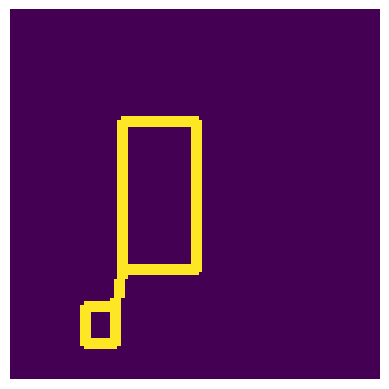

In [53]:
side_distance([30,30,50,70], [20,80,28,90])

### Create images from video

In [4]:
def frames_from_video(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    # Find the number of frames
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    name = video_path.split("/")[-1].split(".")[0]
        
    count=0
            
    while cap.isOpened():
        
        success, frame = cap.read()
                 
              
        cv2.imwrite(f"{output_path}/{name}_frame{count}.jpg", frame)  
        if cv2.waitKey(10) == 27:                     # exit if Escape is hit
            break
        count += 1
        if (count > (video_length)-1):
            
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)

### Collected frames from videos

In [7]:
frames_from_video("videos/industry3.mp4", "frames")

Done extracting frames.
432 frames extracted


In [10]:
frames_from_video("videos/industry2.mp4", "frames")

Done extracting frames.
471 frames extracted


### Val frames

In [12]:
frames_from_video("videos/industry1.mp4", "frames")

Done extracting frames.
340 frames extracted


In [13]:
frames_from_video("videos/industry5.mp4", "frames")

Done extracting frames.
469 frames extracted


In [18]:
frames_from_video("videos/industry7.mp4", "frames")

Done extracting frames.
509 frames extracted


In [19]:
frames_from_video("videos/industry8.mp4", "frames")

Done extracting frames.
697 frames extracted


In [20]:
frames_from_video("videos/industry4.mp4", "frames")

Done extracting frames.
398 frames extracted


In [15]:
frames_from_video("videos/industry5.mp4", "frames")

Done extracting frames.
469 frames extracted


In [21]:
frames_from_video("videos/industry9.mp4", "frames")

Done extracting frames.
656 frames extracted


In [15]:
frames_from_video("videos/industry10.mp4", "frames")

Done extracting frames.
480 frames extracted


In [43]:
frames_from_video("videos/industry14.mp4", "frames")

Done extracting frames.
403 frames extracted


In [5]:
frames_from_video("videos/industry15.mp4", "frames")

Done extracting frames.
462 frames extracted


In [6]:
frames_from_video("videos/industry16.mp4", "frames")

Done extracting frames.
669 frames extracted


In [7]:
frames_from_video("videos/industry17.mp4", "frames")

Done extracting frames.
1032 frames extracted


### Train YOLOv8 on machinery dataset

In [8]:
#Load a model
model = YOLO("yolov8n.pt")  # take pretrained model



# Use the model
model.train(data="data.yaml", epochs=50, imgsz=640, batch=16, pretrained=True, mosaic=0.0)  # train the model

Ultralytics YOLOv8.0.200  Python-3.8.9 torch-2.1.0+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optim

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000018A6FEB5E20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [9]:
results = pd.read_csv("runs/detect/train6/results.csv")

In [11]:
results

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,0.92174,2.10210,1.17320,0.96296,0.19802,0.55476,0.24031,1.2726,2.94340,1.3021,0.000541,0.000541,0.000541
1,2,0.71513,1.23150,0.98663,0.82473,0.30267,0.79190,0.40141,1.3365,2.42170,1.3927,0.001042,0.001042,0.001042
2,3,0.73256,1.07420,1.01690,0.54703,0.25040,0.45832,0.20118,2.1462,2.63750,1.8977,0.001488,0.001488,0.001488
3,4,0.67676,0.92612,0.98908,0.79003,0.84135,0.86616,0.44084,1.7797,1.21380,1.6009,0.001419,0.001419,0.001419
4,5,0.66887,0.77879,0.99266,0.55817,0.56382,0.53214,0.22606,2.1650,2.20960,1.9945,0.001419,0.001419,0.001419
5,6,0.63475,0.68499,0.95615,0.49306,0.39852,0.47645,0.21988,1.9925,2.46120,1.8996,0.001337,0.001337,0.001337
6,7,0.61396,0.60720,0.95403,0.92155,0.89405,0.90879,0.53495,1.4947,0.91226,1.6013,0.001254,0.001254,0.001254
7,8,0.59731,0.54447,0.93676,0.80886,0.72711,0.83678,0.49744,1.5023,1.44750,1.7077,0.001172,0.001172,0.001172
8,9,0.57566,0.50805,0.92317,0.68492,0.77230,0.77522,0.44205,1.8184,1.15390,1.6853,0.001089,0.001089,0.001089
9,10,0.56240,0.45574,0.91696,0.70281,0.77442,0.78365,0.48777,1.5529,1.26470,1.6597,0.001007,0.001007,0.001007


In [10]:
stripped_columns = [column.strip() for column in results.columns]
results.columns = stripped_columns

In [11]:
results.columns

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

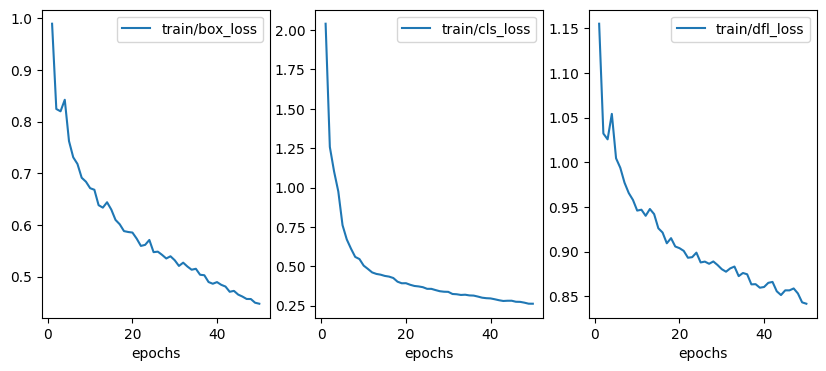

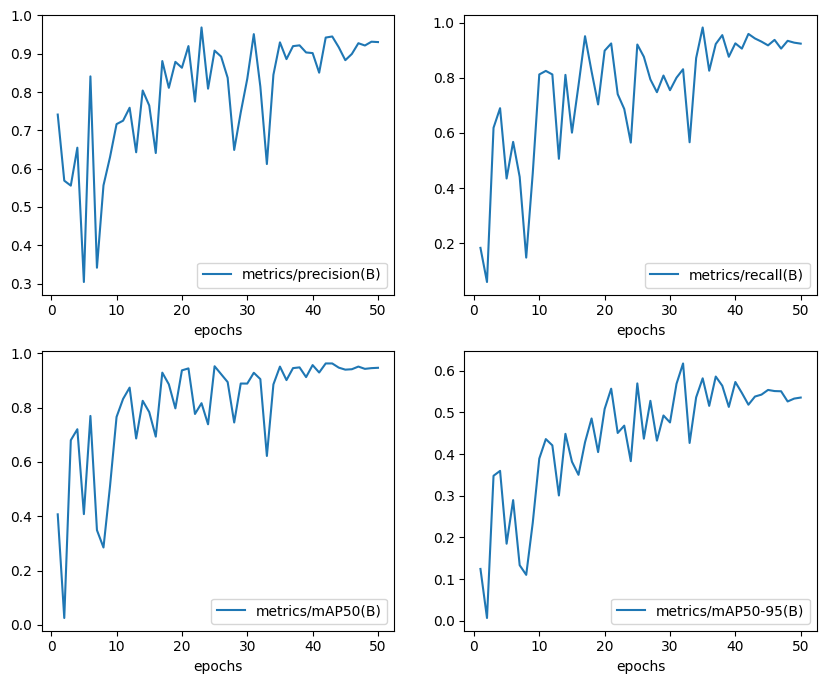

In [12]:
columns = ['train/box_loss','train/cls_loss', 'train/dfl_loss',
           'metrics/precision(B)', 'metrics/recall(B)',
           'metrics/mAP50(B)', 'metrics/mAP50-95(B)']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
for i, column in enumerate(columns[:3]):
    axes[i].plot(results['epoch'], results[column], label=column)
    axes[i].set_xlabel("epochs")
    axes[i].legend(loc="upper right")   
plt.tight_layout
plt.savefig('figures/losses.png')
plt.show()


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
for i, column in enumerate(columns[3:]):
    axes[i//2, i%2].plot(results['epoch'], results[column], label=column)
    axes[i//2, i%2].set_xlabel("epochs")
    axes[i//2, i%2].legend(loc="lower right")   
plt.tight_layout
plt.savefig('figures/metrics.png')
plt.show()

  

### Validation of the trained model

In [13]:
model = YOLO('runs/detect/train6/weights/best.pt')  # load a custom model

# Validate the model
metrics = model.val(data="data.yaml")  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.0.200  Python-3.8.9 torch-2.1.0+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning C:\Projects\Distance_project\data\valid\labels.cache... 101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]
                   all        101        293      0.815      0.832      0.905      0.617
             machinery        101        101      0.853       0.69      0.887      0.629
                person        101        192      0.776      0.974      0.924      0.606
Speed: 1.4ms preprocess, 68.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\val8


In [31]:
!yolo task=detect mode=val model="runs/detect/train/weights/best.pt" data="data.yaml" conf=0.25 source="data/test/images"

Ultralytics YOLOv8.0.199  Python-3.11.6 torch-2.1.0+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs

val: Scanning C:\Projects\Distance_project\data\valid\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
val: Scanning C:\Projects\Distance_project\data\valid\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/7 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:09<00:56,  9.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  29%|██▊       | 2/7 [00:19<00:48,  9.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  43%|████▎     | 3/7 [0

In [5]:
model.predict("videos/test_video/industry2.mp4", save=True, imgsz=640, conf=0.25)



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/471) c:\Projects\Distance_project\videos\test_video\industry2.mp4: 384x640 1 machinery, 2 persons, 126.0ms
video 1/1 (2/471) c:\Projects\Distance_project\videos\test_video\industry2.mp4: 384x640 1 machinery, 2 persons, 71.0ms
video 1/1 (3/471) c:\Projects\Distance_project\videos\test_video\industry2.mp4: 384x640 1 machinery, 2 persons, 70.7ms
video 1/1 (4/471) c:\Projects\Distance_project\videos\test_video\industry2.mp4: 384x640 1 machinery,

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'machinery', 1: 'person'}
 orig_img: array([[[174, 175, 170],
         [115, 116, 111],
         [194, 195, 190],
         ...,
         [ 51,  50,  39],
         [ 50,  49,  38],
         [ 50,  49,  38]],
 
        [[204, 205, 200],
         [188, 189, 184],
         [ 75,  76,  71],
         ...,
         [ 51,  50,  39],
         [ 50,  49,  38],
         [ 50,  49,  38]],
 
        [[193, 194, 189],
         [242, 243, 238],
         [203, 204, 199],
         ...,
         [ 51,  50,  39],
         [ 50,  49,  38],
         [ 50,  49,  38]],
 
        ...,
 
        [[ 99, 116, 120],
         [100, 117, 121],
         [104, 121, 125],
         ...,
         [ 46,  47,  34],
         [ 45,  46,  33],
         [ 45,  46,  33]],
 
        [[102, 119, 123],
         [104, 121, 125],
         [107, 124, 128],
         ...,
         [ 46

### Tracking with bytetrack

In [5]:
model = YOLO('runs/detect/train5/weights/best.pt')
byte_tracker = sv.ByteTrack()

In [6]:
cap = cv2.VideoCapture("videos/industry2.mp4")

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


cap_writer = cv2.VideoWriter('result_industry2.avi', cv2.VideoWriter_fourcc(*'MJPG'),
                        25, (frame_width, frame_height))

success, frame = cap.read()
frame_num=0

while success:
    
    
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)          
    detections = byte_tracker.update_with_detections(detections)
    bboxes = detections.xyxy
    confidences = detections.confidence
    class_ids = detections.class_id
    results = []
    machinery_boxes = []
    people_boxes = []
    for bbox, confidence, class_id in zip(bboxes, confidences, class_ids):
        # results.append({
        # "bbox": bbox.numpy().astype("int"),
        # "confidence": confidence,
        # "class_id": class_id
        # })
        if class_id == 0: #machinery
            machinery_boxes.append(
            bbox.astype("int")
            )
        elif class_id == 1: #person
            people_boxes.append(
            bbox.astype("int")
            )               
                           
        # print(machinery_boxes)
        bbox = bbox.astype("int")
        cv2.rectangle(frame, bbox[:2], bbox[2:], color = (255,0,0), thickness=2)
        cv2.rectangle(frame, (frame_width-100, 20), (frame_width-10, 60), (0,0,0), -1)
        cv2.putText(frame, "%.2f FPS" % get_fps(frame_num), (frame_width-100, 50),
                    cv2.FONT_HERSHEY_SIMPLEX , fontScale = 0.5, color=(255, 255, 255), thickness=1) 
                
    # print(cars_boxes)            
    # d = get_distance(cars_boxes[0], cars_boxes[1])
    # print(d)
                
    for person in people_boxes:
        for machine in machinery_boxes:
            intersection_d = intersection_distance(machine, person)
            side_d = side_distance(machine, person)
            if side_d < 20 or intersection_d > 0:
                cv2.rectangle(frame, person[:2], person[2:], color = (0, 0, 255), thickness=2) 
                cv2.rectangle(frame, machine[:2], machine[2:], color = (0, 0, 255), thickness=2)
                cv2.putText(frame, "ALARM!", (20, 50), cv2.FONT_HERSHEY_SIMPLEX , fontScale = 1, color=(0, 0, 255), thickness=5) 
                            
    imS = cv2.resize(frame, (960, 540))  
    cap_writer.write(frame)      
    cv2.imshow('YOLO V8 Detection', imS)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    success, frame = cap.read()
    frame_num+=1
    

cap.release()

cv2.destroyAllWindows()


0: 384x640 1 machinery, 2 persons, 94.3ms
Speed: 1.0ms preprocess, 94.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 machinery, 2 persons, 78.1ms
Speed: 0.5ms preprocess, 78.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 machinery, 2 persons, 76.4ms
Speed: 0.0ms preprocess, 76.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 machinery, 2 persons, 74.4ms
Speed: 1.0ms preprocess, 74.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 machinery, 2 persons, 73.4ms
Speed: 1.5ms preprocess, 73.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 machinery, 2 persons, 69.7ms
Speed: 5.5ms preprocess, 69.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 machinery, 2 persons, 73.7ms
Speed: 1.5ms preprocess, 73.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 machin

### Convert model to ONNX

In [3]:
model = YOLO('runs/detect/train5/weights/best.pt')
model.export(format="onnx",imgsz=[640,640], opset=12)

Ultralytics YOLOv8.0.200  Python-3.8.9 torch-2.1.0+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs\detect\train3\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (34.9 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ---------------------------------------- 13.3/13.3 MB 17.7 MB/s eta 0:00:00

requirements: AutoUpdate success  15.0s, installed 1 package: ['onnx>=1.12.0']
requirements:  Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.14.1 opset 12...
ONNX: export success  16.6s, saved as 'runs\detect\train3\weights\best.onnx' (11.7 MB)

Export complete (18.5s)
Results saved to C:\Projects\Distance_project\runs\detect\train3\weights
Predict:         yolo predict task=detect model=runs\detect\train3\weights\best.onnx imgsz=640  
Validate:      

'runs\\detect\\train3\\weights\\best.onnx'